In [10]:
import sys, os
sys.path.insert(0, os.getcwd() + "/deep-hedging")

from IPython.display import clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall
from deep_hedging import Deep_Hedging_Model,Delta_SubModel,Deep_Hedging_Model_MLP,Deep_Hedging_Model_MLP_CLAMP
from loss_metrics import Entropy
from utilities import train_test_split

import tensorflow.keras.backend as K

%load_ext autoreload

clear_output()
print("\nFinish installing and importing all necessary libraries!")

ImportError: cannot import name 'Deep_Hedging_Model_MLP' from 'deep_hedging' (/home/gneven/Documents/DL/deep-hedging/deep_hedging/__init__.py)

In [2]:
#@title <font color='Blue'>**User Inputs**</font>

# Geometric Brownian Motion.
N = 5 # Number of time steps (in days)

S0 = 100.0 # Stock price at time = 0
sigma = 0.2 # Implied volatility
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.
initial_wealth = 0.0
# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Day convention.
day_count = ql.Actual365Fixed() # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = 0.0

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda 

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 1 # Number of hidden layers (Note including input nor output layer)         
maxT = 5
# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=50 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

delta_constraint = (0.0, 1.0)
share_stretegy_across_time = False
cost_structure = "constant"

# Other control flags for development purpose.
mc_simulator = "Numpy" # "QuantLib" or "Numpy"


In [3]:
seed = 0 # Random seed. Change to have deterministic outcome.

# Total obs = Training + Testing
nobs = int(Ktrain*(1+Ktest_ratio)) 
		
# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date,calculation_date + 1) 
maturity = N*dt # Maturities (in the unit of a year)

#S0 is init stock price, sigma = Volatility, risk_free = ?, ?,time Day convention
stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = risk_free, \
                        dividend = dividend, day_count = day_count, seed=seed)

S = stochastic_process.gen_path(maturity, N, nobs)

clear_output()

print("\n\ns0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")



s0 = 100.0
sigma = 0.2
risk_free = 0.0

Number of time steps = 5
Length of each time step = 1/365

Simulation Done!


<IPython.core.display.Javascript object>


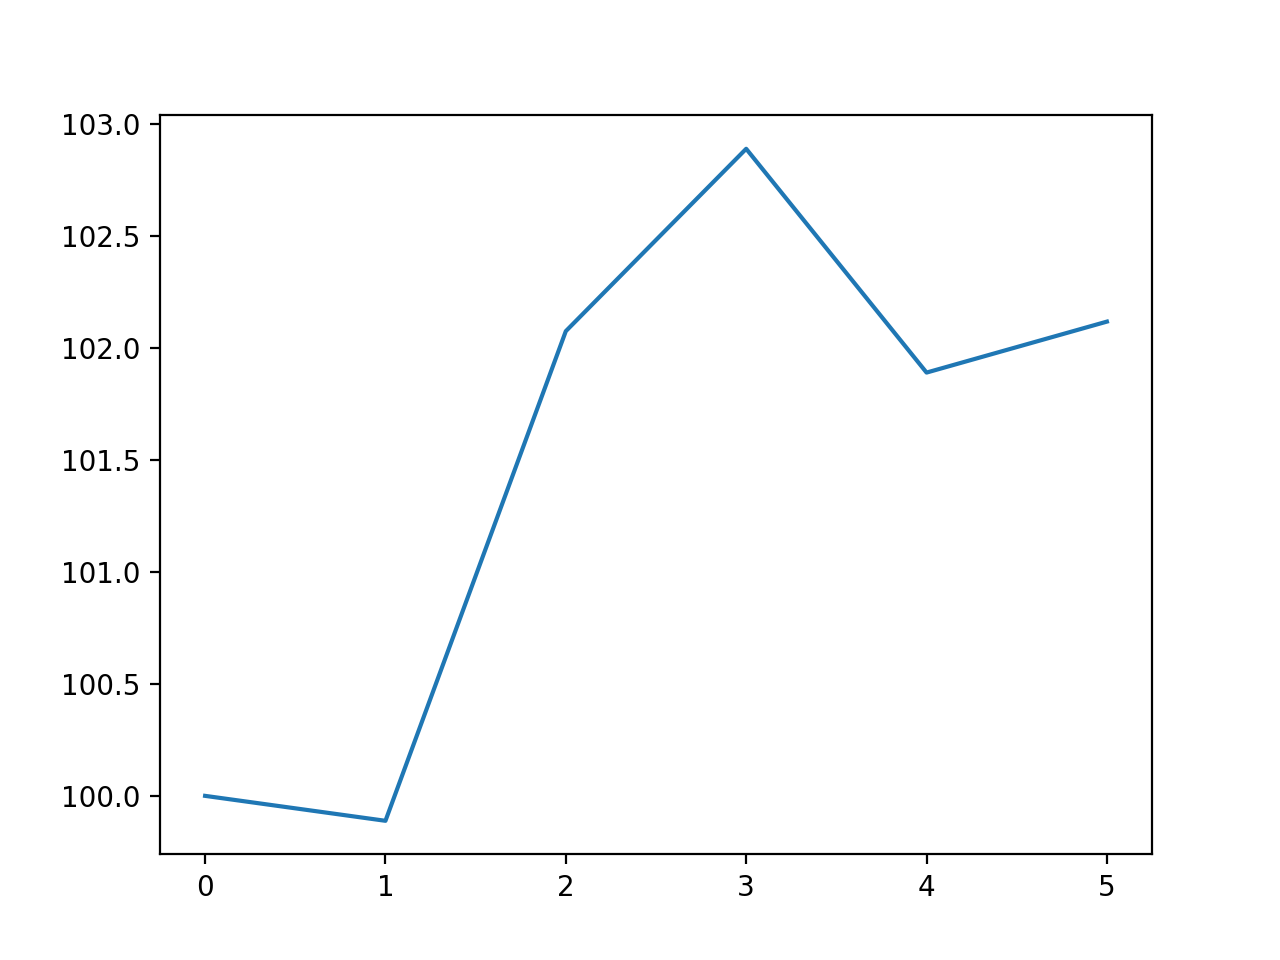

In [4]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.plot(S[0])

In [6]:
#@title <font color='Blue'>**Prepare data to be fed into the deep hedging algorithm.**</font>

payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set

if information_set is "S":
  I =  np.stack((S),axis=1) # Information set
elif information_set is "log_S":
  I =  np.stack((np.log(S)),axis=1)
elif information_set is "normalized_log_S":
  I =  np.stack((np.log(S/S0)),axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S] 
#   3) payoff (dim = 1)
x_all = []
for i in range(N+1):
  x_all += [trade_set[i,:,None]]
  if i != N:
    x_all += [I[i,:,None]]
x_all += [payoff_T[:,None]]

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)
[S_train, S_test] = train_test_split([S], test_size=test_size)
[option_payoff_train, option_payoff_test] = \
    train_test_split([x_all[-1]], test_size=test_size)

print("Finish preparing data!")

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_7972/4048580583.py:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if information_set is "S":
/tmp/ipykernel_7972/4048580583.py:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "log_S":
/tmp/ipykernel_7972/4048580583.py:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "normalized_log_S":


Finish preparing data!


In [9]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Recurrent Network)!**</font>


optimizer = Adam(learning_rate=lr)

# Setup and compile the model maxT=maxT,
model_recurrent = Deep_Hedging_Model_MLP(N=N, d=d, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="recurrent", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost)

loss = Entropy(model_recurrent.output,None,loss_param)
model_recurrent.add_loss(loss)

model_recurrent.compile(optimizer=optimizer)

model_recurrent.summary()

NameError: name 'Deep_Hedging_Model_MLP' is not defined

In [9]:
len(xtrain)

12

In [10]:
Deep_Hedging_Model_LSTM.__name__

NameError: name 'Deep_Hedging_Model_LSTM' is not defined

In [8]:

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_recurrent.fit(x=xtrain, batch_size=64, epochs=2, \
          validation_data=[xtest], verbose=1,callbacks=callbacks)

print("Finished running deep hedging algorithm! (Simple Network)")

2022-01-09 20:21:59.666318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-09 20:21:59.668993: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304500000 Hz


Epoch 1/2


ValueError: in user code:

    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/gneven/anaconda3/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model expects 18 input(s), but it received 12 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 1) dtype=float32>]


In [12]:
option = list()

for w in range(N):

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer("absolutechanges_%i" %w).output)
    option.append(intermediate_layer_model.predict(xtest))
option


NameError: name 'model' is not defined

In [13]:
model = model_recurrent
change_wealth = list()
for w in range(N+1):

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer("wealth_%i" %w).output)
    change_wealth.append(intermediate_layer_model.predict(xtest))
change_wealth

[array([[-50.837357],
        [-50.837357],
        [-50.837357],
        ...,
        [-50.837357],
        [-50.837357],
        [-50.837357]], dtype=float32),
 array([[-54.243477],
        [-64.17164 ],
        [-45.907135],
        ...,
        [-52.85755 ],
        [-43.99233 ],
        [-29.725649]], dtype=float32),
 array([[-70.43306 ],
        [-67.51236 ],
        [-84.520424],
        ...,
        [-40.270348],
        [-24.920202],
        [-22.26849 ]], dtype=float32),
 array([[-63.75641 ],
        [-89.43098 ],
        [-98.263916],
        ...,
        [-12.83366 ],
        [-19.939468],
        [-20.324606]], dtype=float32),
 array([[ -99.84364 ],
        [ -93.55518 ],
        [-100.40063 ],
        ...,
        [ -15.902391],
        [ -40.629112],
        [ -30.488468]], dtype=float32),
 array([[-1.2312822 ],
        [-0.70097065],
        [-1.2612967 ],
        ...,
        [-0.7899933 ],
        [-0.5473784 ],
        [-0.7217083 ]], dtype=float32)]

In [45]:
model = model_recurrent
change_wealth = list()
for w in range(N):

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer("costDot_%i" %w).output)
    change_wealth.append(intermediate_layer_model.predict(xtest))
change_wealth

[array([[-0.],
        [-0.],
        [-0.],
        ...,
        [-0.],
        [-0.],
        [-0.]], dtype=float32),
 array([[-50.626682],
        [-50.626682],
        [-50.626682],
        ...,
        [-50.626682],
        [-50.626682],
        [-50.626682]], dtype=float32),
 array([[-50.895058],
        [-54.66146 ],
        [-59.574432],
        ...,
        [-78.14523 ],
        [-51.313957],
        [-56.884315]], dtype=float32),
 array([[-87.027176],
        [-50.472824],
        [-54.668636],
        ...,
        [-91.132805],
        [-37.54697 ],
        [-35.54348 ]], dtype=float32),
 array([[-87.85104 ],
        [-44.06232 ],
        [-42.546467],
        ...,
        [-83.99057 ],
        [-22.199757],
        [-13.176508]], dtype=float32)]

In [32]:
import pandas as pd
#options = pd.DataFrame(np.array(option)[:,:,0])
wealths = pd.DataFrame(np.array(change_wealth)[:,:,0])
fig,ax = plt.subplots()

#ax.plot(options[0],label='options')
ax.plot(wealths.iloc[:,:],label='wealth')

ax.set(ylabel='Wealth',xlabel='Days',title='Wealth movement')

fig,ax = plt.subplots()

#ax.plot(options,label='options')
#ax.plot(wealths,label='wealth')

#ax.set(ylabel='Options',xlabel='Days')
change_wealth

NameError: name 'change_wealth' is not defined

In [32]:
wealths

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,...,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
1,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,...,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182,-50.34182


In [13]:
#@title <font color='Blue'>**Results: Option Prices**</font>
call = EuropeanCall()

price_BS = call.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)
delta_BS = call.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = risk_free, \
              final_period_cost=final_period_cost, epsilon=epsilon, \
              cost_structure = cost_structure )

risk_neutral_price = \
    -option_payoff_test[0].mean()*np.exp(-risk_free*(N*dt))
nn_simple_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % nn_simple_price)

try:
  nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)
  print("The Deep Hedging (with recurrent network) price is %2.3f." % nn_recurrent_price)
except:
  print("No Recurrent model.")


The Black-Scholes model price is 0.934.
The Risk Neutral price is 0.940.
The Deep Hedging (with simple network) price is 0.995.
The Deep Hedging (with recurrent network) price is 0.995.


<IPython.core.display.Javascript object>


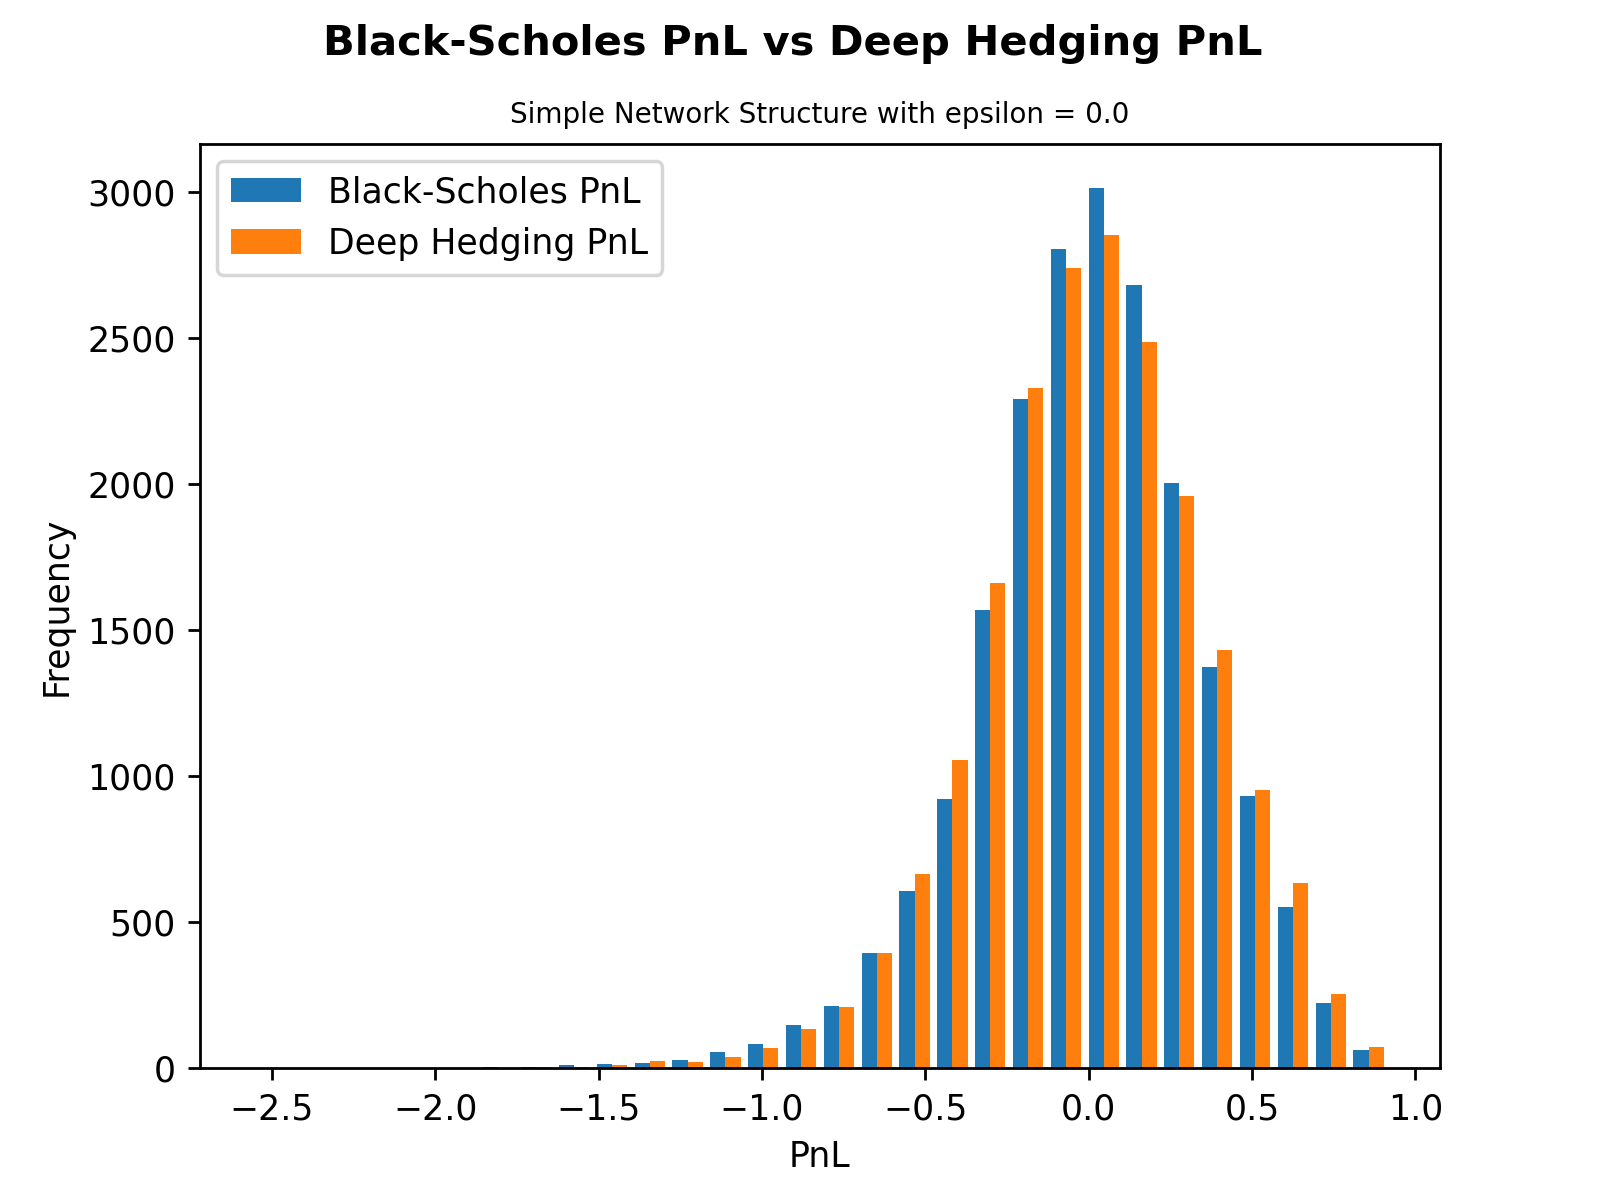

In [45]:
#@title <font color='Blue'>**Results: Black-Scholes PnL vs Deep Hedging PnL**</font>
bar1 = PnL_BS +risk_neutral_price #+ price_BS[0][0]
bar2 = model_recurrent(xtest).numpy().squeeze() +risk_neutral_price#+ price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
      fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes PnL", "Deep Hedging PnL"])
ax.legend()
plt.show()

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_5486/839409396.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if information_set is "S":
/tmp/ipykernel_5486/839409396.py:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "log_S":
/tmp/ipykernel_5486/839409396.py:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "normalized_log_S":


<IPython.core.display.Javascript object>


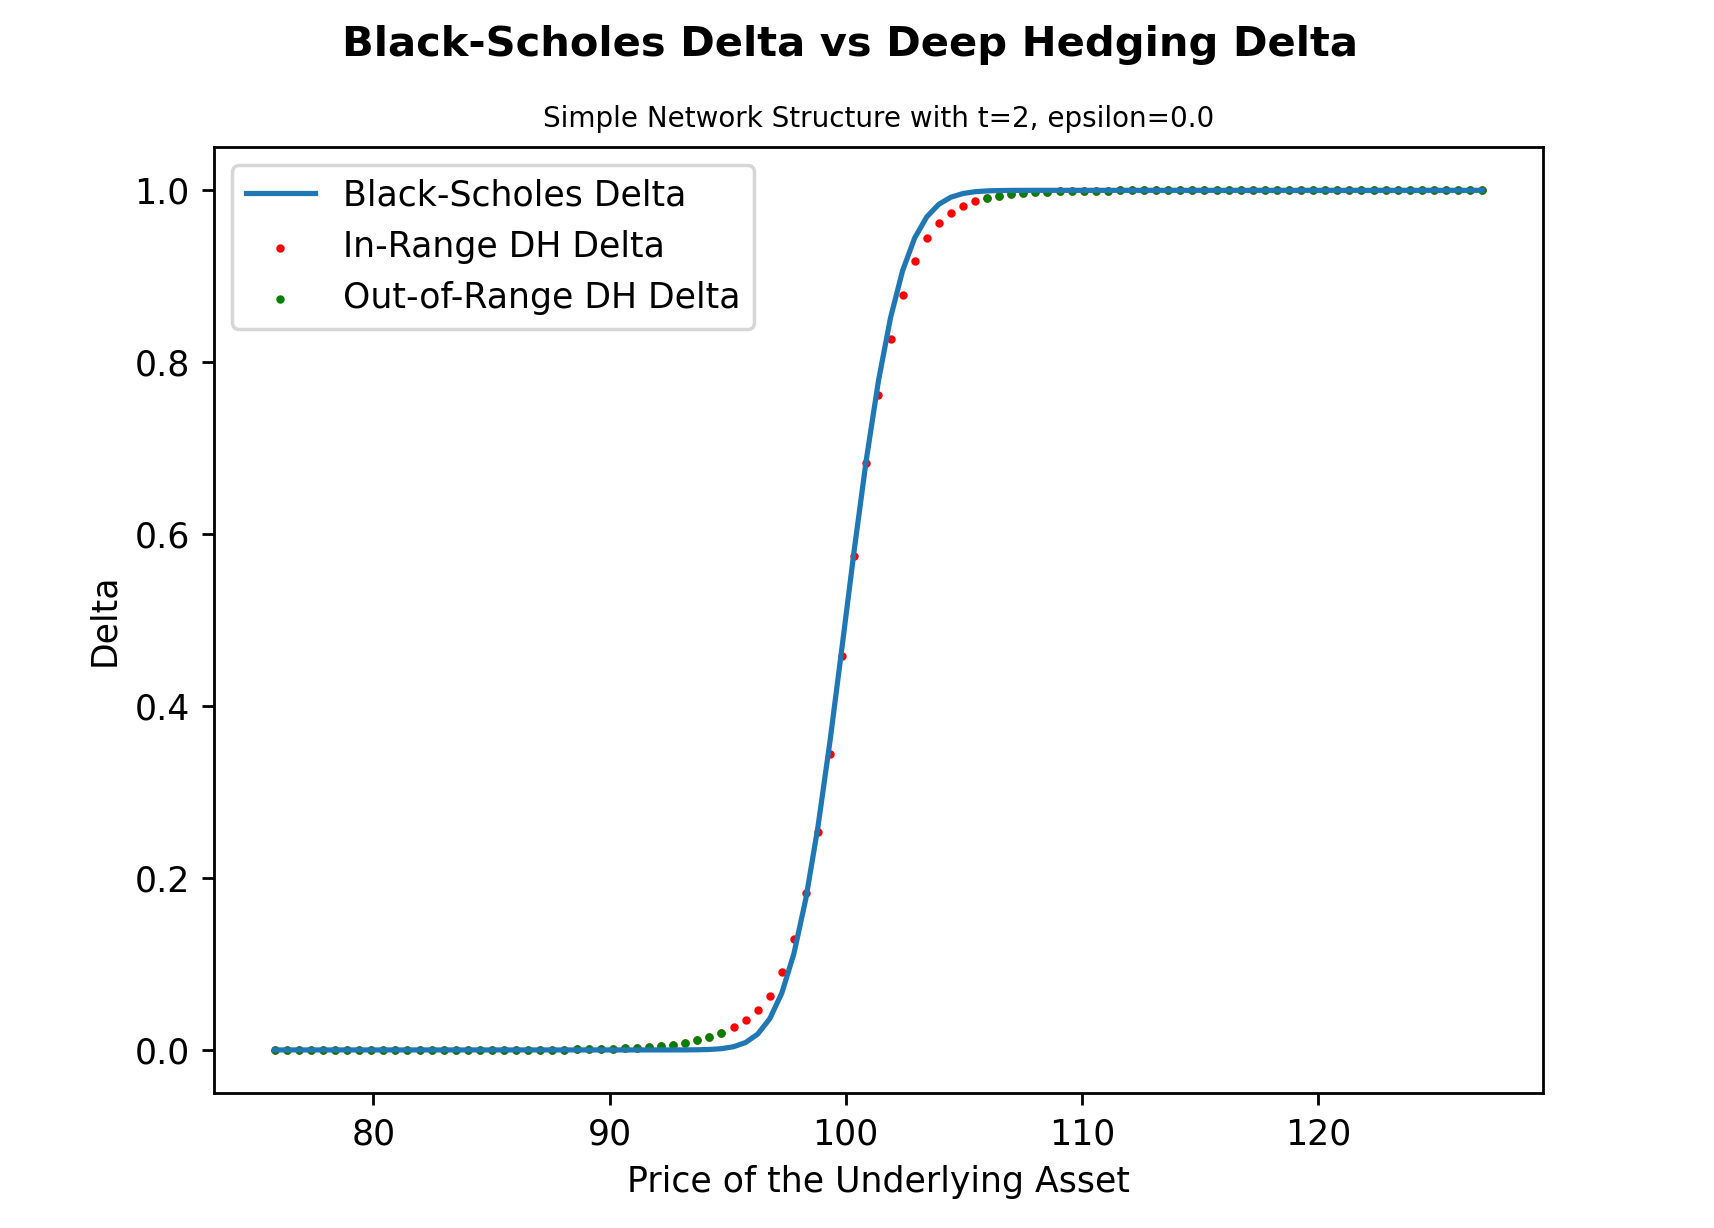

In [31]:
from tensorflow.keras.layers import Input,Concatenate
#@title <font color='Blue'>**Results: Extrapolation**</font>
days_from_today = 2
tau = (N-days_from_today)*dt
  
min_S = S_test[0][:,days_from_today].min()
max_S = S_test[0][:,days_from_today].max()

S_range = np.linspace(min_S*0.8,max_S*1.2,101)

in_sample_range = S_range[np.any([S_range>=min_S, S_range <= max_S], axis=0)]
out_sample_range_low = S_range[S_range<min_S]
out_sample_range_high = S_range[S_range>max_S]

# Attention: Need to transform it to be consistent with the information set.
if information_set is "S":
  I_range =  S_range # Information set
elif information_set is "log_S":
  I_range =  np.log(S_range)
elif information_set is "normalized_log_S":
  I_range =  np.log(S_range/S0)        
    
# Compute Black-Scholes delta for S_range.
# Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
d1 = (np.log(S_range) - np.log(strike) + \
      (risk_free - dividend + (sigma**2)/2)*tau) \
            / (sigma*np.sqrt(tau))  
              
model_delta = norm.cdf(d1)*np.exp(-dividend*tau)

model = model_recurrent
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("delta_%i" %days_from_today).output)

inputs = [Input(1,), Input(1,)]
intermediate_inputs = Concatenate()(inputs)

outputs = model.get_layer("delta_" + str(days_from_today))(intermediate_inputs)

MODEL = Model(inputs, outputs)

nn_delta = MODEL.predict([I_range,I_range])



# Create a plot of Black-Scholes delta against deep hedging delta.
fig_delta = plt.figure(dpi= 125, facecolor='w')
fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
      fontweight="bold")
ax_delta = fig_delta.add_subplot()
ax_delta.set_title("Simple Network Structure with " + \
            "t=" + str(days_from_today) + ", " + \
              "epsilon=" + str(epsilon), \
              fontsize=8)
ax_delta.set_xlabel("Price of the Underlying Asset")
ax_delta.set_ylabel("Delta")
ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")
ax_delta.scatter(in_sample_range,nn_delta[np.any([S_range>=min_S, S_range <= max_S], axis=0)], c="red", s=2, label="In-Range DH Delta")
ax_delta.scatter(out_sample_range_low,nn_delta[S_range<min_S], c="green", s=2, label="Out-of-Range DH Delta")
ax_delta.scatter(out_sample_range_high,nn_delta[S_range>max_S], c="green", s=2)

ax_delta.legend()
plt.show()

In [29]:
MODEL.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 2)            0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
delta_2 (Strategy_Layer)        (None, 1)            61          concatenate_10[0][0]       

In [ ]:
class Strategy_Layer(tf.keras.layers.Layer):
    def __init__(self, d = None, m = None, use_batch_norm = None, \
        kernel_initializer = "he_uniform", \
        activation_dense = "relu", activation_output = "linear", 
        delta_constraint = None, day = None):
        super().__init__(name = "delta_" + str(day))
        self.d = d
        self.m = m
        self.use_batch_norm = use_batch_norm
        self.activation_dense = activation_dense
        self.activation_output = activation_output
        self.delta_constraint = delta_constraint
        self.kernel_initializer = kernel_initializer
        
        self.intermediate_dense = [None for _ in range(d)]
        self.intermediate_BN = [None for _ in range(d)]
        bias_initializer=he_uniform()

        for i in range(d):
           self.intermediate_dense[i] = Dense(self.m,    
                        kernel_initializer=self.kernel_initializer,
                        bias_initializer=bias_initializer,
                        use_bias=(not self.use_batch_norm))
           if self.use_batch_norm:
               self.intermediate_BN[i] = BatchNormalization(momentum = 0.99, trainable=True)
           
        self.output_dense = Dense(1, 
                      kernel_initializer=self.kernel_initializer,
                      bias_initializer = bias_initializer,
                      use_bias=True)     
        
    def call(self, input):
        for i in range(self.d):
            if i == 0:
                output = self.intermediate_dense[i](input)
            else:
                output = self.intermediate_dense[i](output)                  
                
            if self.use_batch_norm:
 			    # Batch normalization.
                output = self.intermediate_BN[i](output, training=True)
                
            if self.activation_dense == "leaky_relu":
                output = LeakyReLU()(output)
            else:
                output = Activation(self.activation_dense)(output)
         
        output = self.output_dense(output)
					 
        if self.activation_output == "leaky_relu":
            output = LeakyReLU()(output)
        elif self.activation_output == "sigmoid" or self.activation_output == "tanh" or \
            self.activation_output == "hard_sigmoid":
            # Enforcing hedge constraints
            if self.delta_constraint is not None:
                output = Activation(self.activation_output)(output)
                delta_min, delta_max = self.delta_constraint
                output = Lambda(lambda x : (delta_max-delta_min)*x + delta_min)(output)
            else:
                output = Activation(self.activation_output)(output)
        
        return output

In [ ]:
prc = Input(shape=(1,), name = "prc_0")
information_set = Input(shape=(1,), name = "information_set_0")
strategy_type="recurrent"
inputs = [prc, information_set]
past_strategy = list()
maxT = 5
for j in range(N+1):            
    if j < N:
        # Define the inputs for the strategy layers here.
        if strategy_type == "simple":
            helper1 = information_set
        elif strategy_type == "recurrent":
            if j ==0:
                # Tensorflow hack to deal with the dimension problem.
                #   Strategy at t = -1 should be 0. 
                # There is probably a better way but this works.
                # Constant tensor doesn't work.
                strategy = Lambda(lambda x: x*0.0)(prc)

            past_strategy.append(strategy)
            helper = past_strategy[-maxT:]
            helper.append(information_set)
            #helper1 = tf.stack(helper,axis=1)
            helper1 = Concatenate()([information_set,strategy])
        # Determine if the strategy function depends on time t or not.
        if not share_stretegy_across_time:
            strategy_layer = Strategy_Layer(d = d, m = m, 
                         use_batch_norm = use_batch_norm, \
                         kernel_initializer = kernel_initializer, \
                         activation_dense = activation_dense, \
                         activation_output = activation_output, 
                         delta_constraint = delta_constraint, \
                         day = j)

            strategyhelper = strategy_layer(helper1)

        else:
            if j == 0:
                strategyhelper1 = LSTM(m,return_sequences=False,
                                      kernel_initializer=kernel_initializer,
                        bias_initializer=he_uniform())(helper1,training=True)
                strategyhelper = Dense(1,kernel_initializer=kernel_initializer,
                        bias_initializer=he_uniform())(strategyhelper1,training=True)

                strategyhelper = BatchNormalization(momentum = 0.99,
                                trainable=True)(strategyhelper,training=True)
        # strategy_-1 is set to 0
        # delta_strategy = strategy_{t+1} - strategy_t
        if j == 0:              
            delta_strategy = strategyhelper
        else:
            delta_strategy = Subtract(name = "diff_strategy_" + str(j))([strategyhelper, strategy])

        if cost_structure == "proportional": 
            # Proportional transaction cost
            absolutechanges = Lambda(lambda x : K.abs(x), name = "absolutechanges_" + str(j))(delta_strategy)
            costs = Dot(axes=1)([absolutechanges,prc])
            costs = Lambda(lambda x : epsilon*x, name = "cost_" + str(j))(costs)
        elif cost_structure == "constant":
            # Tensorflow hack..
            costs = Lambda(lambda x : epsilon + x*0.0)(prc)

        if j == 0:
            wealth = Lambda(lambda x : initial_wealth - x, name = "costDot_" + str(j))(costs)
        else:
            wealth = Subtract(name = "costDot_" + str(j))([wealth, costs])

        # Wealth for the next period
        # w_{t+1} = w_t + (strategy_t-strategy_{t+1})*prc_t
        #         = w_t - delta_strategy*prc_t
        mult = Dot(axes=1)([delta_strategy, prc])
        wealth = Subtract(name = "wealth_" + str(j))([wealth, mult])

        # Accumulate interest rate for next period.
        FV_factor = np.exp(risk_free*dt)
        wealth = Lambda(lambda x: x*FV_factor)(wealth)

        prc = Input(shape=(1,),name = "prc_" + str(j+1))
        information_set = Input(shape=(1,), name = "information_set_" + str(j+1))

        strategy = strategyhelper    

        if j != N - 1:
            inputs += [prc, information_set]
        else:
            inputs += [prc]
    else:
        # The paper assumes no transaction costs for the final period 
        # when the position is liquidated.
        if final_period_cost:
            if cost_structure == "proportional":
                # Proportional transaction cost
                absolutechanges = Lambda(lambda x : K.abs(x), name = "absolutechanges_" + str(j))(strategy)
                costs = Dot(axes=1)([absolutechanges,prc])
                costs = Lambda(lambda x : epsilon*x, name = "cost_" + str(j))(costs)
            elif cost_structure == "constant":
                # Tensorflow hack..
                costs = Lambda(lambda x : epsilon + x*0.0)(prc)

            wealth = Subtract(name = "costDot_" + str(j))([wealth, costs])
        # Wealth for the final period
        # -delta_strategy = strategy_t
        mult = Dot(axes=1)([strategy, prc])
        wealth = Add()([wealth, mult])

        # Add the terminal payoff of any derivatives.
        payoff = Input(shape=(1,), name = "payoff")
        inputs += [payoff]

        wealth = Add(name = "wealth_" + str(j))([wealth,payoff])
        model = Model(inputs=inputs, outputs=wealth)


In [ ]:
def Entropy_loss(wealth=None, w=None, loss_param=None):
    _lambda = loss_param

    return (1/_lambda)*K.log(K.mean(K.exp(-_lambda*wealth)))

model.compile(optimizer=Adam(learning_rate=lr),loss=Entropy_loss)

model.summary()

'Deep_Hedging_Model_LSTM, Deep_Hedging_Model_Transformer'